# Chapter: Exploratory Data Analysis: Getting to Know Your Data Well


# Topic: Data characteristics assessment of TEP data

In [1]:
# import required packages
import numpy as np, matplotlib.pyplot as plt
from ennemi import pairwise_corr
import scipy.spatial, scipy.stats
from statsmodels.graphics.tsaplots import acf
from sklearn.mixture import GaussianMixture

plt.rcParams.update({'font.size': 20})

In [2]:
# fetch TE data
TEdata_noFault_train = np.loadtxt('d00.dat').T

# select data for continuous measured and manipulated variables
xmeas = TEdata_noFault_train[:,0:22]
xmv = TEdata_noFault_train[:,41:52]
data = np.hstack((xmeas, xmv))

In [3]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                      Nonlinearity Assessment
#   Code adapted from KydLIB package (Copyright (c) 2022 afraniomelo; https://github.com/afraniomelo/KydLIB/) shared under MIT License (https://github.com/afraniomelo/KydLIB?tab=MIT-1-ov-file#readme)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [4]:
#%% compute linear and Nonlinear correlation coefficients
# pair-wise linear correlation coefficients
rho_xy = np.corrcoef(data, rowvar=False)

# pair-wise MI
rho_I_xy = pairwise_corr(data)
np.fill_diagonal(rho_I_xy,1) # replace diagonal nan values with ones

# pair-wise nonlinear correlation coefficients
rxy = rho_I_xy*(1-np.abs(rho_xy))

# overall coefficients
m = data.shape[1]
r = np.sqrt((rxy**2).sum()/(m**2-m))
rho = np.sqrt(((rho_xy**2).sum()-m)/(m**2-m))
print('Overall nonlinearity coefficient:' , r)
print('Overall linearity coefficient:' , rho)

Overall nonlinearity coefficient: 0.20966472903041783
Overall linearity coefficient: 0.20258248260809983


In [5]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                    check for non-gaussianity
# Code adapted from KydLIB package (Copyright (c) 2022 afraniomelo; https://github.com/afraniomelo/KydLIB/) shared under MIT License (https://github.com/afraniomelo/KydLIB?tab=MIT-1-ov-file#readme)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Intercept, Slope:  -2.2194775769453443 1.144746493310787
S / Fbar:  0.010631943736892396
Gaussianity:  False


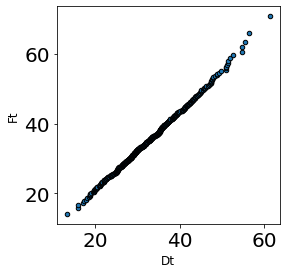

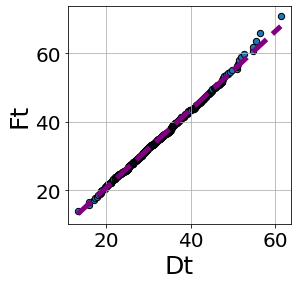

In [7]:
# find data statistics
N = data.shape[0]
m = data.shape[1]

mu = np.mean(data, axis=0)
S = np.cov(data, rowvar=False, ddof=1)
S_inv = np.linalg.pinv(S)

# calculate D statistic and the fractiles and plot Dt vs Ft
D = np.array([scipy.spatial.distance.mahalanobis(data[i,:], mu, S_inv)**2 for i in range(N)])
Dt = np.sort(D)
rt = [(t-0.5)/N for t in range(1,N+1)]

factor = m*(N**2-1)/(N*(N-m))
Ft = factor*np.array([scipy.stats.f.ppf(p, m, N-m) for p in rt])

plt.figure(figsize=(4,4))
plt.scatter(Dt, Ft, edgecolor='black', s=20)
plt.xlabel('Dt', fontsize=12)
plt.ylabel('Ft', fontsize=12)

# fit a straight line
linearFit = scipy.stats.linregress(Dt,Ft)
intercept, slope = linearFit[1], linearFit[0]
print('Intercept, Slope: ', intercept, slope)

# draw staright line
x = np.linspace(Dt[0], Dt[-1])
y = slope*x + intercept

plt.figure(figsize=(4, 4))
plt.scatter(Dt, Ft, edgecolor='black', s=40)
plt.plot(x, y, color='purple', ls='--', lw=5)
plt.xlabel('Dt', fontsize=25)
plt.ylabel('Ft', fontsize=25)
plt.grid()

# perform significance tests and make inference
Fbar = np.mean(Ft)
S = np.sqrt(((Ft-(intercept+slope*Dt))**2).sum()/(N-2))
S_by_Fbar = S/Fbar
print('S / Fbar: ', S_by_Fbar)

if S_by_Fbar > 0.15:
    gaussianity = False
else:
    if np.abs(slope-1) < 0.2 and np.abs(intercept) < Fbar*0.05:
        gaussianity = True
    else:
        gaussianity = False

print('Gaussianity: ', gaussianity)

plt.show()

In [8]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                       Dynamics Assessment
#   Below code adapted from KydLIB package (Copyright (c) 2022 afraniomelo; https://github.com/afraniomelo/KydLIB/) shared under MIT License (https://github.com/afraniomelo/KydLIB?tab=MIT-1-ov-file#readme)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

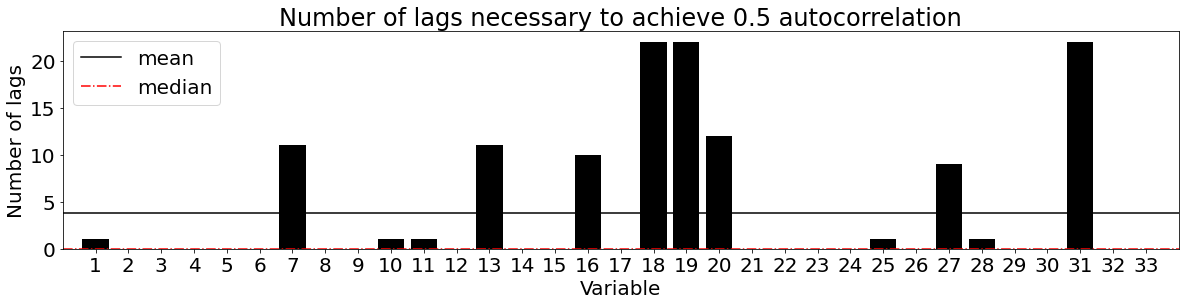

In [10]:
# compute ACF values for each variable
nlags = 50
ACF_for_all_vars = [] # each entry contains ACF values for nlags for a single variable
lags_x = np.arange(1,nlags+1)

for i in range(m):
    ACF_single_var = acf(data[:,i],nlags=nlags)[1:] # not including the ACF at lag 0
    ACF_for_all_vars.append(ACF_single_var)
 
# bar plot showing lags necessary to achieve <=0.5 autocorrelation for each variable
lags_necessary = [np.searchsorted(-ACF_for_all_vars[i], -0.5) for i in range(len(ACF_for_all_vars))]

plt.figure(figsize=(20,4))
plt.bar(range(1,len(lags_necessary)+1), np.array(lags_necessary), color='k');
plt.xlabel('Variable'), plt.ylabel('Number of lags')
plt.xlim([0,m+1]);
plt.xticks(np.arange(1,m+1));
plt.axhline(np.mean(lags_necessary), ls='-',c='k',label='mean')
plt.axhline(np.median(lags_necessary),ls='-.', c='red',label='median')
plt.legend()
plt.title('Number of lags necessary to achieve 0.5 autocorrelation')
plt.grid()

plt.grid()

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                       Multimodality Assessment
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

C:\Users\f0ne44\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\f0ne44\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\f0ne44\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\f0ne44\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Wi

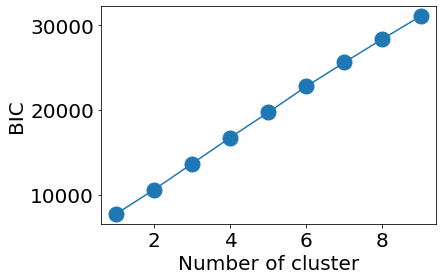

In [11]:
BICs = []
lowestBIC = np.inf
for n_cluster in range(1, 10):
    gmm = GaussianMixture(n_components = n_cluster, random_state = 100)
    gmm.fit(data)
    BIC = gmm.bic(data)
    BICs.append(BIC)
    
    if BIC < lowestBIC:
        optimal_n_cluster = n_cluster 
        lowestBIC = BIC

plt.figure()
plt.plot(range(1, len(BICs)+1), BICs, marker='o', ms=15)
plt.xlabel('Number of cluster')
plt.ylabel('BIC')

plt.show()